In [1]:
from __future__ import division
from __future__ import print_function

import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import sys
sys.path.append("/home/marta/jku/SBNet/ssnet_fop")

import pandas as pd
from scipy import random
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
# import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

from tqdm import tqdm
from retrieval_model import FOP


In [2]:
torch.cuda.is_available()

True

In [3]:
# data_folder = '/home/marta/jku/LLaVA/mmimdb'
data_folder = '/share/hel/datasets/mmimdb'

In [4]:
texts_folder = os.path.join(data_folder, 'llava_encoded_texts')

train_text_df = os.path.join(texts_folder, 'llava_plot_first_latent_train.csv')
test_text_df = os.path.join(texts_folder, 'llava_plot_first_latent_test.csv')

images_folder = os.path.join(data_folder, 'llava_encoded_images')

train_image_df = os.path.join(images_folder, 'llava_images_latent_train.csv')
test_image_df = os.path.join(images_folder, 'llava_images_latent_test.csv')

labels = ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir',
       'history', 'horror', 'music', 'musical', 'mystery', 'news',
       'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show',
       'thriller', 'war', 'western']

In [5]:
def read_data(FLAGS):

    print('Split Type: %s'%(FLAGS.split_type))

    if FLAGS.split_type == 'text_only':
        print('Reading Text Train')
        train_file_text = train_text_df
        train_data = pd.read_csv(train_file_text, index_col='item_id')
        train_label = train_data[labels]
        train_data = train_data.drop(columns=labels)
        train_data = np.asarray(train_data)
        # Shuffle the data also if only one modality is used
        # combined = list(zip(train_data, train_label))
        # random.shuffle(combined)
        # train_data, train_label = zip(*combined)

        return train_data, train_label

    elif FLAGS.split_type == 'image_only':
        print('Reading Image Train')
        train_file_image = train_image_df
        train_data = pd.read_csv(train_file_image, index_col='item_id')
        train_label = train_data[labels]
        train_data = train_data.drop(columns=labels)
        train_data = np.asarray(train_data)
        # Shuffle the data also if only one modality is used
        # combined = list(zip(train_data, train_label))
        # random.shuffle(combined)
        # train_data, train_label = zip(*combined)

        return train_data, train_label

def get_batch(batch_index, batch_size, labels, f_lst):
    start_ind = batch_index * batch_size
    end_ind = (batch_index + 1) * batch_size
    return np.asarray(f_lst[start_ind:end_ind]), np.asarray(labels[start_ind:end_ind])

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def main(train_data, train_label):
    """
    train_data.shape = (num_train_instances, embedding_size)
    train_label.shape = (num_train_instances, num_labels)
    """
    n_class = train_label.shape[1]
    train_label_np = np.asarray(train_label)
    model = FOP(FLAGS, train_data.shape[1], n_class)
    model.apply(init_weights)
    
    # ce_loss = nn.CrossEntropyLoss().cuda()
    bce_logits_loss = nn.BCEWithLogitsLoss().cuda()
    
    if FLAGS.cuda:
        model.cuda()
        # ce_loss.cuda()    
        bce_logits_loss.cuda()
        cudnn.benchmark = True
    
    optimizer = optim.Adam(model.parameters(), lr=FLAGS.lr, weight_decay=0.01)

    n_parameters = sum([p.data.nelement() for p in model.parameters()])
    print('  + Number of params: {}'.format(n_parameters))
    
    
    epoch = 1
    # todo check: why len and not train_label[0] ? 
    print(len(train_label), FLAGS.batch_size)
    num_of_batches = (len(train_label) // FLAGS.batch_size)
    loss_plot = []
    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    
    loss_per_epoch = 0.
    txt_dir = 'output'
    save_dir = 'fc2_%s_%s'%(FLAGS.split_type, FLAGS.save_dir)
    txt = '%s/bce_%03d.txt'%(txt_dir, FLAGS.max_num_epoch)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if not os.path.exists(txt_dir):
        os.makedirs(txt_dir)
    
    with open(txt,'w+') as f:
        f.write('EPOCH\tLOSS\ttrain precision\ttrain recall\ttrain f1\n')
    
    save_best = 'best_%s'%(save_dir)
    
    if not os.path.exists(save_best):
        os.mkdir(save_best)
    with open(txt,'a+') as f:
        # performing early stopping on f1
        max_f1 = 0.
        while (epoch < FLAGS.max_num_epoch):
            print('%s\tEpoch %03d'%(FLAGS.split_type, epoch))
            for idx in tqdm(range(num_of_batches)):
                train_batch, batch_labels = get_batch(idx, FLAGS.batch_size, train_label, train_data)
                # voice_feats, _ = get_batch(idx, FLAGS.batch_size, train_label, voice_train)
                loss_tmp = train_on_batch(train_batch, batch_labels, model, optimizer, bce_logits_loss)
                loss_per_epoch += loss_tmp
            
            # todo check: should we really divide by the number of batches? this leads to an incorrect loss 
            #  if the last batch is smaller.
            loss_per_epoch /= num_of_batches
            
            loss_plot.append(loss_per_epoch)
#                 print(train_data.shape, train_label.shape)
            precision, recall, f1 = model_eval(train_data, train_label_np, model)
            train_precision_list.append(precision)
            train_recall_list.append(recall)
            train_f1_list.append(f1)
            
            save_checkpoint({
               'epoch': epoch,
               'state_dict': model.state_dict()}, save_dir, 'checkpoint_%04d_%0.3f.pth.tar'%(epoch, f1*100))

            # print('==> Epoch: %d/%d Loss: %0.2f Alpha:%0.2f, Min_train_f1: %0.2f'%(epoch, FLAGS.max_num_epoch, loss_per_epoch, alpha, min(train_f1_list)))
            if f1 > max_f1:
                max_f1 = f1
                save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict()}, save_best, 'checkpoint.pth.tar')
            f.write('%04d\t%0.4f\t%0.2f\t%0.2f\t%0.2f\n'%(epoch, loss_per_epoch, precision, recall, f1))
            loss_per_epoch = 0.
            epoch += 1
    
    return loss_plot, train_f1_list


def model_eval(train_batch, labels, model):
    model.eval()
    with torch.no_grad():
        train_batch = torch.from_numpy(train_batch).float()
        
        if FLAGS.cuda:
            train_batch = train_batch.cuda()
        train_batch = Variable(train_batch)
        comb = model.train_forward(train_batch)
        
        predictions = torch.sigmoid(comb[1]).cpu().numpy()
        predictions = (predictions > 0.5).astype(int)
        
        precision = precision_score(labels, predictions, average='samples')
        recall = recall_score(labels, predictions, average='samples')
        f1 = f1_score(labels, predictions, average='samples')
        
        return precision, recall, f1
    
    
def train_on_batch(train_batch, labels, model, optimizer, bce_logits_loss):   
    
#     optimizer.zero_grad()
    
    average_loss = RunningAverage()
    model.train()
    train_batch = torch.from_numpy(train_batch).float()
    labels = torch.from_numpy(labels).float()
    
    if FLAGS.cuda:
        train_batch, labels = train_batch.cuda(), labels.cuda()

    train_batch, labels = Variable(train_batch), Variable(labels)
    features, logits = model.train_forward(train_batch)
    
    loss = bce_logits_loss(logits, labels) 
    loss.backward()
    optimizer.step()  
    
    optimizer.zero_grad()
    
    average_loss.update(loss.item())
    return average_loss.avg()

class RunningAverage(object):
    def __init__(self):
        self.value_sum = 0.
        self.num_items = 0. 

    def update(self, val):
        self.value_sum += val 
        self.num_items += 1

    def avg(self):
        average = 0.
        if self.num_items > 0:
            average = self.value_sum / self.num_items

        return average

def save_checkpoint(state, directory, filename):
    filename = os.path.join(directory, filename)
    torch.save(state, filename)
    

In [6]:
global FLAGS

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random Seed')
parser.add_argument('--cuda', action='store_true', default=True, help='CUDA Training')
parser.add_argument('--save_dir', type=str, default='model', help='Directory for saving checkpoints.')
parser.add_argument('--lr', type=float, default=1e-5, metavar='LR',
                    help='learning rate (default: 1e-5)') 
parser.add_argument('--batch_size', type=int, default=128, help='Batch size for training.')
parser.add_argument('--max_num_epoch', type=int, default=50, help='Max number of epochs to train, number')
parser.add_argument('--dim_embed', type=int, default=256,
                    help='Embedding Size')
parser.add_argument('--split_type', type=str, default='text_only', help='split_type')

_StoreAction(option_strings=['--split_type'], dest='split_type', nargs=None, const=None, default='text_only', type=<class 'str'>, choices=None, help='split_type', metavar=None)

In [8]:
FLAGS, unparsed = parser.parse_known_args()

In [9]:
train_data, train_label = read_data(FLAGS)

Split Type: text_only
Reading Text Train


In [10]:
print('Split Type: %s'%(FLAGS.split_type))

Split Type: text_only


In [11]:
losses, f1_scores = main(train_data, train_label)

/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


  + Number of params: 1909019
15552 128
text_only	Epoch 001


100%|██████████| 121/121 [00:00<00:00, 166.37it/s]


text_only	Epoch 002


100%|██████████| 121/121 [00:00<00:00, 163.89it/s]


text_only	Epoch 003


100%|██████████| 121/121 [00:00<00:00, 163.31it/s]


text_only	Epoch 004


100%|██████████| 121/121 [00:00<00:00, 171.97it/s]


text_only	Epoch 005


100%|██████████| 121/121 [00:00<00:00, 164.35it/s]


text_only	Epoch 006


100%|██████████| 121/121 [00:00<00:00, 172.47it/s]


text_only	Epoch 007


100%|██████████| 121/121 [00:00<00:00, 174.43it/s]


text_only	Epoch 008


100%|██████████| 121/121 [00:00<00:00, 175.11it/s]


text_only	Epoch 009


100%|██████████| 121/121 [00:00<00:00, 176.47it/s]


text_only	Epoch 010


100%|██████████| 121/121 [00:00<00:00, 163.24it/s]


text_only	Epoch 011


100%|██████████| 121/121 [00:00<00:00, 209.63it/s]


text_only	Epoch 012


100%|██████████| 121/121 [00:00<00:00, 207.46it/s]


text_only	Epoch 013


100%|██████████| 121/121 [00:00<00:00, 208.35it/s]


text_only	Epoch 014


100%|██████████| 121/121 [00:00<00:00, 209.74it/s]


text_only	Epoch 015


100%|██████████| 121/121 [00:00<00:00, 208.09it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 016


100%|██████████| 121/121 [00:00<00:00, 169.78it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 017


100%|██████████| 121/121 [00:00<00:00, 173.24it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 018


100%|██████████| 121/121 [00:00<00:00, 172.85it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 019


100%|██████████| 121/121 [00:00<00:00, 172.49it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 020


100%|██████████| 121/121 [00:00<00:00, 164.82it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 021


100%|██████████| 121/121 [00:00<00:00, 170.28it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 022


100%|██████████| 121/121 [00:00<00:00, 172.54it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 023


100%|██████████| 121/121 [00:00<00:00, 170.04it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 024


100%|██████████| 121/121 [00:00<00:00, 169.06it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 025


100%|██████████| 121/121 [00:00<00:00, 169.37it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 026


100%|██████████| 121/121 [00:00<00:00, 171.43it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 027


100%|██████████| 121/121 [00:00<00:00, 173.43it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 028


100%|██████████| 121/121 [00:00<00:00, 171.60it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 029


100%|██████████| 121/121 [00:00<00:00, 162.43it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 030


100%|██████████| 121/121 [00:00<00:00, 166.17it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 031


100%|██████████| 121/121 [00:00<00:00, 174.54it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 032


100%|██████████| 121/121 [00:00<00:00, 176.70it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 033


100%|██████████| 121/121 [00:00<00:00, 177.83it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 034


100%|██████████| 121/121 [00:00<00:00, 176.56it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 035


100%|██████████| 121/121 [00:00<00:00, 177.36it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 036


100%|██████████| 121/121 [00:00<00:00, 177.80it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 037


100%|██████████| 121/121 [00:00<00:00, 177.51it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 038


100%|██████████| 121/121 [00:00<00:00, 176.38it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 039


100%|██████████| 121/121 [00:00<00:00, 177.23it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 040


100%|██████████| 121/121 [00:00<00:00, 177.76it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 041


100%|██████████| 121/121 [00:00<00:00, 177.47it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 042


100%|██████████| 121/121 [00:00<00:00, 177.50it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 043


100%|██████████| 121/121 [00:00<00:00, 170.91it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 044


100%|██████████| 121/121 [00:00<00:00, 167.28it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 045


100%|██████████| 121/121 [00:00<00:00, 167.18it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 046


100%|██████████| 121/121 [00:00<00:00, 168.43it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 047


100%|██████████| 121/121 [00:00<00:00, 167.36it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 048


100%|██████████| 121/121 [00:00<00:00, 171.30it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text_only	Epoch 049


100%|██████████| 121/121 [00:00<00:00, 168.56it/s]
/home/marta/miniconda3/envs/sbnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
f1_scores

[0.15691801057225999,
 0.16405682962090354,
 0.17214950707624227,
 0.18123555800376498,
 0.19225027918879578,
 0.20661909933040204,
 0.2207369106347575,
 0.2394729340827755,
 0.2571094634919182,
 0.2746825076372105,
 0.29494853384909026,
 0.31466469598517843,
 0.3343293424870677,
 0.35348253939505175,
 0.3732633460855245,
 0.3891527391656015,
 0.4006699060611124,
 0.408959715010909,
 0.41484384443832234,
 0.41627148779861717,
 0.41681249981235463,
 0.41542989323748786,
 0.4143413446231324,
 0.4112070175410641,
 0.411026342319433,
 0.4111202671362296,
 0.4116801652571162,
 0.4049546277428443,
 0.39761460618877514,
 0.3974836257923948,
 0.3941575553759086,
 0.3954746988966205,
 0.39528020478549947,
 0.3970935901489517,
 0.3943477327434382,
 0.39556807379595615,
 0.39702353893969317,
 0.3961419254339033,
 0.39209614462177717,
 0.395811774062563,
 0.3975265947772595,
 0.3953977652485266,
 0.39682659475327975,
 0.3952832864265666,
 0.39650383829872754,
 0.39548361026665313,
 0.3965566459558

In [13]:
losses

[0.7023756124756553,
 0.7005342905186425,
 0.6986562048108125,
 0.6969740316887533,
 0.6951755329597095,
 0.6933920777533665,
 0.6914833084610869,
 0.6896045464129488,
 0.6877075138170857,
 0.6856644744715414,
 0.6836010601894915,
 0.6816685795783997,
 0.6795509827038473,
 0.6775820491727719,
 0.6753952542612375,
 0.6733921593870998,
 0.6711812846916766,
 0.6690961743189283,
 0.6668398976325989,
 0.6645250990371073,
 0.6621303523867583,
 0.6595995293175878,
 0.6569820913401517,
 0.6542356698966223,
 0.6516561902259007,
 0.6491360358955446,
 0.6465171816920446,
 0.6435278072830074,
 0.6396529644974007,
 0.6362831385667659,
 0.6339390573422771,
 0.6317996087153096,
 0.6298891685225747,
 0.627799480907188,
 0.6258112310378019,
 0.6239206584031917,
 0.6220136378422256,
 0.6202434276746325,
 0.6182648982883485,
 0.6163755724252749,
 0.6145841454671435,
 0.6126745165872179,
 0.6109058743666026,
 0.6090123958824095,
 0.6073216263912926,
 0.6054598733413318,
 0.603766023620101,
 0.601940561917

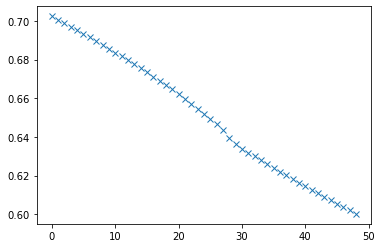

In [14]:
import matplotlib.pyplot as plt
ar = np.arange(len(losses)) # just as an example array
plt.plot(ar, losses, 'x')
plt.show()

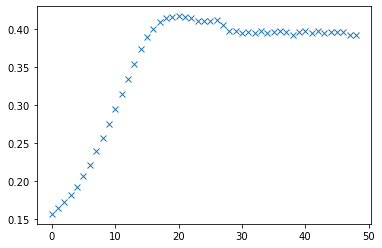

In [15]:
import matplotlib.pyplot as plt
ar = np.arange(len(losses)) # just as an example array
plt.plot(ar, f1_scores, 'x')
plt.show()